In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import pingouin as pg 
#from outliers import smirnov_grubbs as grubbs
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#from ipynb.fs.full.Redox_Functions import isNormal,HasEqualVariance,CompareRedox,RemoveOutliers_CompareRedox

## Functions

In [3]:
def isNormal(df,list):
    norm=pd.DataFrame(columns=['Rxn_condition','PopSize','testStat','Pval','normal?'])

    x=list

    for i in x:
        sub=df[df['Redox']==i]
        pop2=sub['HalfLife (days)'].dropna()
        pop2=pop2.astype(float)
        count=len(pop2.index)
        if count >=3:
            stat=scipy.stats.shapiro(pop2).statistic
            pval=scipy.stats.shapiro(pop2).pvalue
            
            if count >= 30:
                q='yes'
            elif pval <= 0.05:
                q='no'
            else:
                q='yes'
            norm.loc[len(norm)]={'Rxn_condition' : i,'PopSize':count, 'testStat': stat,'Pval':pval, 'normal?': q}
    return norm

In [4]:
def HasEqualVariance(df,norm):
    var=pd.DataFrame(columns=['Rxn_condition','Rxn_num','testStat','Pval','equal_var?'])
    pop1=df['HalfLife (days)'].dropna()
    pop1=pop1.astype(float)
    
    x=list(norm.loc[norm['normal?']=='yes','Rxn_condition'])

    for i in x:
        sub=df[df['Redox']==i]
        pop2=sub['HalfLife (days)'].dropna()
        pop2=pop2.astype(float)
        count=len(pop2.index)
        stat=scipy.stats.levene(pop1,pop2).statistic
        pval=scipy.stats.levene(pop1,pop2).pvalue
    
        if pval < 0.05:
            q='no'
        else:
            q='yes'
    
        var.loc[len(var)]={'Rxn_condition' : i,'Rxn_num':count, 'testStat': stat,'Pval':pval, 'equal_var?': q}
    return var

In [5]:
def CompareRedox(df,norm,var):
    results=pd.DataFrame(columns=['Rxn_condition','Rxn_avg','Rxn_std','PopSize','test_stat','pval','sig?','test'])
    
    pop1=df['HalfLife (days)'].dropna()
    pop1=pop1.astype(float)
    mean1=df['HalfLife (days)'].astype(float).mean()
    std1=df['HalfLife (days)'].astype(float).std()
    nobs1=len(pop1)

    redox=list(norm['Rxn_condition'])
    t=list(var.loc[var['equal_var?']=='yes','Rxn_condition']) #is normal with equal variance
    wt=list(var.loc[var['equal_var?']=='no','Rxn_condition']) #is normal but not equal variance
    kw=list(norm.loc[norm['normal?']=='no', 'Rxn_condition']) #not normal

    for i in redox:
        
        sub=df[df['Redox']==i]
        avg=sub['HalfLife (days)'].astype(float).mean()
        count=len(sub.index)
        std2=sub['HalfLife (days)'].astype(float).std()
        pop2=sub['HalfLife (days)'].dropna()
        pop2=pop2.astype(float)
            
        if i in t:
            #stat=scipy.stats.ttest_ind_from_stats(mean1,std1,nobs1,avg,std2,count,equal_var=True,alternative='two-sided').statistic
            stat=scipy.stats.ttest_1samp(pop2,mean1,axis=0,nan_policy= 'omit',alternative='two-sided').statistic
            #pval=scipy.stats.ttest_ind_from_stats(mean1,std1,nobs1,avg,std2,count,equal_var=True,alternative='two-sided').pvalue
            pval=scipy.stats.ttest_1samp(pop2,mean1,axis=0,nan_policy= 'omit',alternative='two-sided').pvalue
            test='t-test'
        elif i in kw:
            stat=scipy.stats.kruskal(pop1,pop2).statistic
            pval=scipy.stats.kruskal(pop1,pop2).pvalue
            test='Kruskal-Wallis'
        elif i in wt:
            stat=scipy.stats.ttest_ind_from_stats(mean1,std1,nobs1,avg,std2,count,equal_var=False,alternative='two-sided').statistic
            pval=scipy.stats.ttest_ind_from_stats(mean1,std1,nobs1,avg,std2,count,equal_var=False,alternative='two-sided').pvalue
            test='Welchs t-test'
        if pval <= 0.05:
            s='yes'
        else:
            s='no'
        results.loc[len(results)]={'Rxn_condition' : i, 'Rxn_avg': avg,'Rxn_std':std2, 'PopSize': count, 
                                'test_stat':stat, 'pval':pval,'sig?':s,'test':test}
        results=results.sort_values(by=['PopSize'],ascending=False)
    return results

In [6]:
#lit=pd.read_excel('Updated_AnaerobicRxn_LitLib_05072024.xlsx') #results in paper currently
#lit=pd.read_excel('Updated_AnaerobicRxn_LitLib_06112024_parentType.xlsx')
lit=pd.read_excel('Updated_AnaerobicRxn_LitLib_06132024_parentType.xlsx')

#omit data point that were reported for having a 'stable' half life for the purpose of this analysis
lit=lit[lit['HalfLife (days)']!='stable']
#drop rows with no half life
lit=lit[lit['HalfLife (days)'].notna()]

In [7]:
#list of nitro reducing schemes
nitro=['Reduction: Hydroxyl aromatic amine to aromatic amine','Reduction: Nitroaromatic to aromatic amine',
       'Reduction: Nitroaromatic to nitrosoaromatic', 'Reduction: Nitrosoaromatic to hydroxylaminearomatic']

#subset lit data to include examples only using nitro schemes
df=lit[lit['Rxn_Scheme'].isin(nitro)==True]
df.head()

,Scheme,Category,Rxn_Type,Rxn,Rxn_Scheme,Redox,LibDoc_Check,LibDoc_Check_Notes,Parent_Type,Parent,...,RateConstant_avg,RateConstant_avg2,QA_Check,QA_Revisions,QA_Rate,QA_HalfLife,Reference,DOI,std_Parent_SMILES,std_Product_SMILES
7,NaN,Reduction,Reduction,Nitroaromatic to aromatic amine,Reduction: Nitroaromatic to aromatic amine,Fe,NaN,NaN,Initial,Nitrobenzene,...,NaN,NaN,"Results and Discussion -- ""Since the reduction...",NaN,NaN,NaN,"Heijman,CG et al. (1995)",10.1021/es00003a027,O=[N+]([O-])c1ccccc1,Nc1ccccc1
8,NaN,Reduction,Reduction,Nitroaromatic to aromatic amine,Reduction: Nitroaromatic to aromatic amine,Fe,NaN,NaN,Initial,Nitrobenzene,...,NaN,0.11685,NaN,NaN,NaN,NaN,"Nielsen,PH et al. (1995B)",10.1016/0169-7722(95)00026-R,O=[N+]([O-])c1ccccc1,Nc1ccccc1
9,NaN,Reduction,Reduction,Nitroaromatic to aromatic amine,Reduction: Nitroaromatic to aromatic amine,Fe,NaN,NaN,Initial,Nitrobenzene,...,NaN,0.00370,NaN,NaN,NaN,NaN,"Nielsen,PH et al. (1995B)",10.1016/0169-7722(95)00026-R,O=[N+]([O-])c1ccccc1,Nc1ccccc1
10,NaN,Reduction,Reduction,Nitroaromatic to aromatic amine,Reduction: Nitroaromatic to aromatic amine,Fe,NaN,NaN,Initial,Nitrobenzene,...,NaN,0.00370,NaN,NaN,NaN,NaN,"Nielsen,PH et al. (1995B)",10.1016/0169-7722(95)00026-R,O=[N+]([O-])c1ccccc1,Nc1ccccc1
11,NaN,Reduction,Reduction,Nitroaromatic to aromatic amine,Reduction: Nitroaromatic to aromatic amine,Fe,NaN,NaN,Initial,Nitrobenzene,...,NaN,0.00370,NaN,NaN,NaN,NaN,"Nielsen,PH et al. (1995B)",10.1016/0169-7722(95)00026-R,O=[N+]([O-])c1ccccc1,Nc1ccccc1


In [8]:
#get redox state by scheme
test=df.groupby('Redox',as_index=False)['HalfLife (days)'].unique().apply(list)
test

,Redox,HalfLife (days)
0,Fe,"[0.00144375, 5.930680359435172, 187.2972972972..."
1,Meth,[187.2972972972973]
2,NO3,[187.2972972972973]
3,methanogenic,"[0.356294759, 78.35549496, 0.575132144]"
4,nitrate reducing,"[1.122724255, 4.890562196, 0.292495587, 0.0016..."
5,sulfate reducing,"[1.15283575, 1.302244676, 0.300966076, 0.58280..."


In [9]:
#one-way anova
meth=[0.356294759, 78.35549496, 0.575132144]
nit=[1.122724255, 4.890562196, 0.292495587, 0.001606452, 0.013211193,0.001332174, 0.28875]
sul=[1.15283575, 1.302244676, 0.300966076, 0.582806077,1.404662502, 62.447456, 0.010768065]
scipy.stats.f_oneway(meth,nit,sul)

F_onewayResult(statistic=1.3076238643889793, pvalue=0.3015424809117799)

In [10]:
#get sample size counts for each redox condition
df.groupby('Redox', as_index=False)['HalfLife (days)'].count()

,Redox,HalfLife (days)
0,Fe,5
1,Meth,2
2,NO3,1
3,methanogenic,3
4,nitrate reducing,7
5,sulfate reducing,7


In [11]:
df.groupby('Redox')['HalfLife (days)'].median()

Redox
Fe                  187.297297
Meth                187.297297
NO3                 187.297297
methanogenic          0.575132
nitrate reducing       0.28875
sulfate reducing      1.152836
Name: HalfLife (days), dtype: object

In [12]:
x=['sulfate reducing', 'nitrate reducing', 'methanogenic']

### Test for normal distribution in data
shapiro-wilkes test

if data is normal or pop size is greater than 30, equal variance can be tested using Levene's, and a t test (equal variances) or welches t test(unequal variances) can be used to compare means.
Otherewise, use kruskal walace test 

In [13]:
sub_norm=isNormal(df,x)
sub_var=HasEqualVariance(df,sub_norm)
CompareRedox(df,sub_norm,sub_var)

,Rxn_condition,Rxn_avg,Rxn_std,PopSize,test_stat,pval,sig?,test
0,sulfate reducing,9.600248,23.309367,7,0.520589,0.470591,no,Kruskal-Wallis
1,nitrate reducing,0.944383,1.784386,7,4.860435,0.027479,yes,Kruskal-Wallis
2,methanogenic,26.428974,44.969819,3,0.037895,0.845653,no,Kruskal-Wallis


### Full data

In [14]:
lit['Redox'].replace(to_replace=['SO4','SO4?'], value= 'sulfate reducing', inplace =True)
lit['Redox'].replace(to_replace=['methanogenesis','Meth'], value = 'methanogenic', inplace=True)
lit['Redox'].replace(to_replace=['Fe'], value='iron reducing', inplace=True)
lit['Redox'].replace(to_replace=['Meth/SO4','sulfate reducing; methanogenic'], value='sulfate reducing/methanogenic', inplace=True)
lit['Redox'].replace(to_replace=['NO3','N2O','nitrogen reducing','NO3/Mn'],value='nitrate reducing',inplace=True) #Mn is coupled with nitrate reducing redox zone
lit['Redox'].replace(to_replace=['SO4/Fe'],value='iron reducing/sulfate reducing',inplace=True)
lit['Redox'].replace(to_replace=['SO4/Fe'],value='iron reducing/sulfate reducing',inplace=True)
lit['Redox'].replace(to_replace=['NO3/SO4'],value='nitrate reducing/sulfate reducing',inplace=True)
lit['Redox'].replace(to_replace=['Meth/Fe/Mn'],value='nitrate reducing/iron reducing/methanogenic',inplace=True) #Mn is coupled with nitrate reducing redox zone
lit['Redox'].replace(to_replace=['Meth/Fe/SO4','Fe/Meth/SO4','Meth/SO4/Fe'],value='iron reducing/sulfate reducing/methanogenic',inplace=True)
lit['Redox'].replace(to_replace=['NO3/Fe/SO4/Meth'],value='nitrate reducing/iron reducing/sulfate reducing/methanogenic',inplace=True)
lit['Redox'].fillna('Undefined',inplace=True)

In [15]:
big_x= lit['Redox'].unique()
big_x

array(['iron reducing', 'iron reducing/sulfate reducing/methanogenic',
       'methanogenic', 'nitrate reducing/iron reducing/methanogenic',
       'sulfate reducing/methanogenic', 'nitrate reducing',
       'nitrate reducing/iron reducing/sulfate reducing/methanogenic',
       'nitrate reducing/sulfate reducing', 'sulfate reducing',
       'iron reducing/sulfate reducing', 'Undefined'], dtype=object)

In [16]:

big_norm=isNormal(lit,big_x)
big_norm

,Rxn_condition,PopSize,testStat,Pval,normal?
0,iron reducing,54,0.341626,3.595113e-14,yes
1,iron reducing/sulfate reducing/methanogenic,10,0.554487,1.593393e-05,no
2,methanogenic,159,0.125280,1.130707e-26,yes
3,nitrate reducing/iron reducing/methanogenic,7,0.673630,1.897451e-03,no
4,sulfate reducing/methanogenic,45,0.647067,3.758152e-09,yes
5,nitrate reducing,191,0.241956,2.613787e-27,yes
6,nitrate reducing/iron reducing/sulfate reducin...,6,0.928908,5.716926e-01,yes
7,nitrate reducing/sulfate reducing,7,0.629784,6.045502e-04,no
8,sulfate reducing,154,0.169055,9.116838e-26,yes
9,iron reducing/sulfate reducing,18,0.899815,5.703356e-02,yes


In [17]:
big_var=HasEqualVariance(lit,big_norm)
big_var

,Rxn_condition,Rxn_num,testStat,Pval,equal_var?
0,iron reducing,54,7.748825,0.005488,no
1,methanogenic,159,0.253512,0.614723,yes
2,sulfate reducing/methanogenic,45,0.000628,0.980008,yes
3,nitrate reducing,191,1.283575,0.257498,yes
4,nitrate reducing/iron reducing/sulfate reducin...,6,0.008580,0.926219,yes
5,sulfate reducing,154,0.560194,0.454359,yes
6,iron reducing/sulfate reducing,18,0.240207,0.624182,yes
7,Undefined,193,0.479460,0.488822,yes


In [18]:
final=CompareRedox(lit,big_norm,big_var)
final
#final.to_excel('tTestResults_06122024.xlsx',index=False)

,Rxn_condition,Rxn_avg,Rxn_std,PopSize,test_stat,pval,sig?,test
10,Undefined,165.952194,733.572471,193,-1.101729,0.271959,no,t-test
5,nitrate reducing,129.432356,556.797805,191,-2.350429,0.019777,yes,t-test
2,methanogenic,178.154532,1124.813456,159,-0.515372,0.607013,no,t-test
8,sulfate reducing,301.961274,1623.171444,154,0.595064,0.552680,no,t-test
0,iron reducing,705.574529,2068.430915,54,-1.695190,0.095702,no,Welchs t-test
4,sulfate reducing/methanogenic,244.698001,396.112906,45,0.348362,0.729229,no,t-test
9,iron reducing/sulfate reducing,133.737959,110.388672,18,-3.474003,0.002903,yes,t-test
1,iron reducing/sulfate reducing/methanogenic,198.550869,375.428852,10,3.522898,0.060527,no,Kruskal-Wallis
3,nitrate reducing/iron reducing/methanogenic,105.966004,162.712126,7,2.668550,0.102349,no,Kruskal-Wallis
7,nitrate reducing/sulfate reducing,72.266316,113.957135,7,0.016622,0.897417,no,Kruskal-Wallis


In [58]:
lit['HalfLife (days)']=lit['HalfLife (days)'].astype(float)
table4=lit.groupby('Redox')['HalfLife (days)'].describe()
table4=table4.reindex(index=['nitrate reducing','iron reducing','sulfate reducing','methanogenic','Undefined',
                      'nitrate reducing/iron reducing/sulfate reducing/methanogenic',
                      'nitrate reducing/iron reducing/methanogenic','nitrate reducing/sulfate reducing',
                      'iron reducing/sulfate reducing/methanogenic','iron reducing/sulfate reducing','sulfate reducing/methanogenic'])
dfMed=lit.groupby('Redox')['HalfLife (days)'].median().reset_index(name='median')
df=pd.merge(table4,dfMed, how='left', left_index=True,right_on='Redox')
df=df.reindex(columns=['Redox','count','mean','median','min','max'])
#df.to_excel('RedoxDescriptiveStat_Table4_06272024.xlsx',index=False)

In [28]:
total=final['PopSize'].sum()
total-198

646

In [29]:
len(lit['HalfLife (days)'])

844

In [30]:
160+191+154+54

559

In [31]:
#drop nan
lit=lit[lit['HalfLife (days)'].notna()]

#anova, comparing means against each other
sul=list(lit.loc[lit['Redox']=='sulfate reducing','HalfLife (days)'].astype(float))
nit=list(lit.loc[lit['Redox']=='nitrate reducing','HalfLife (days)'].astype(float))
iron=list(lit.loc[lit['Redox']=='iron reducing','HalfLife (days)'].astype(float))
meth=list(lit.loc[lit['Redox']=='methanogenic','HalfLife (days)'].astype(float))
blank=list(lit.loc[lit['Redox']=='Undefined','HalfLife (days)'].astype(float))
scipy.stats.f_oneway(sul,nit,iron,meth)

F_onewayResult(statistic=3.1615878333907435, pvalue=0.02427562300408976)

In [32]:
#res=scipy.stats.tukey_hsd(sul,nit,iron,meth,blank)
res=scipy.stats.tukey_hsd(sul,nit,iron,meth)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    172.529     0.590  -180.928   525.986
 (0 - 2)   -403.613     0.184  -919.766   112.539
 (0 - 3)    123.807     0.823  -245.185   492.799
 (1 - 0)   -172.529     0.590  -525.986   180.928
 (1 - 2)   -576.142     0.017 -1079.148   -73.136
 (1 - 3)    -48.722     0.984  -399.089   301.644
 (2 - 0)    403.613     0.184  -112.539   919.766
 (2 - 1)    576.142     0.017    73.136  1079.148
 (2 - 3)    527.420     0.042    13.379  1041.461
 (3 - 0)   -123.807     0.823  -492.799   245.185
 (3 - 1)     48.722     0.984  -301.644   399.089
 (3 - 2)   -527.420     0.042 -1041.461   -13.379



In [33]:
#test if all big 4 data is normal
b4=['nitrate reducing','iron reducing', 'sulfate reducing', 'methanogenic']
big4=lit[lit['Redox'].isin(b4)==True]
pop1=big4['HalfLife (days)'].astype(float)
res=scipy.stats.shapiro(pop1)
print(res)

ShapiroResult(statistic=0.18133270740509033, pvalue=1.0930128021733573e-43)


<Axes: xlabel='HalfLife (days)', ylabel='Density'>

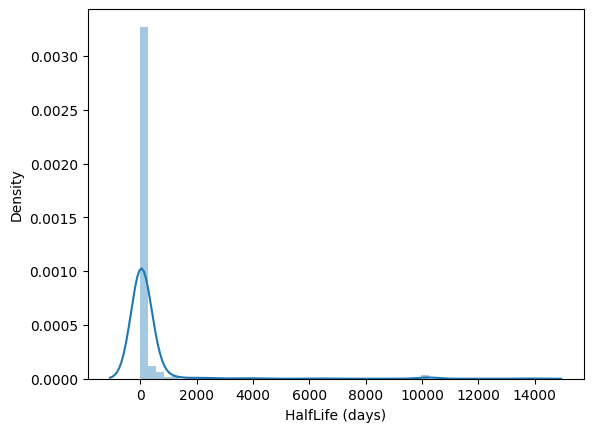

In [34]:
sns.distplot(pop1)

In [35]:
scipy.stats.levene(sul,nit,iron,meth)

LeveneResult(statistic=2.955588026314154, pvalue=0.03200663228006462)

In [49]:
scipy.stats.bartlett(sul,nit,iron,meth)

BartlettResult(statistic=221.01686996715654, pvalue=1.210322410117696e-47)

In [50]:
#test if all big 4 has equal variance

var=pd.DataFrame(columns=['Rxn_condition','Rxn_num','testStat','Pval','equal_var?'])

for i in b4:
    sub=big4[big4['Redox']==i]
    pop2=sub['HalfLife (days)']
    count=len(pop2.index)
    stat=scipy.stats.levene(pop1,pop2).statistic
    pval=scipy.stats.levene(pop1,pop2).pvalue

    if pval < 0.05:
        q='no'
    else:
        q='yes'

    var.loc[len(var)]={'Rxn_condition' : i,'Rxn_num':count, 'testStat': stat,'Pval':pval, 'equal_var?': q}
var

,Rxn_condition,Rxn_num,testStat,Pval,equal_var?
0,nitrate reducing,191,1.480091,0.224145,yes
1,iron reducing,54,5.079106,0.024570,no
2,sulfate reducing,154,0.199510,0.655253,yes
3,methanogenic,159,0.405650,0.524389,yes


In [26]:
test=big4.astype({'HalfLife (days)':'float'})

pg.welch_anova(data=test, dv='HalfLife (days)', between='Redox')

,Source,ddof1,ddof2,F,p-unc,np2
0,Redox,3,173.925635,1.835778,0.142428,0.016832


In [27]:
#make subset of lit data to only include b4
sub4=lit[lit['Redox'].isin(b4)==True]

In [28]:
# lit['Redox'].replace(to_replace=['nitrate reducing/iron reducing/sulfate reducing/methanogenic', 
#                                  'sulfate reducing/methanogenic','iron reducing/sulfate reducing/methanogenic',
#                                  'nitrate reducing/iron reducing/methanogenic','nitrate reducing/sulfate reducing',
#                                  'Undefined','iron reducing/sulfate reducing'], value= 'undefined/mix',inplace=True)

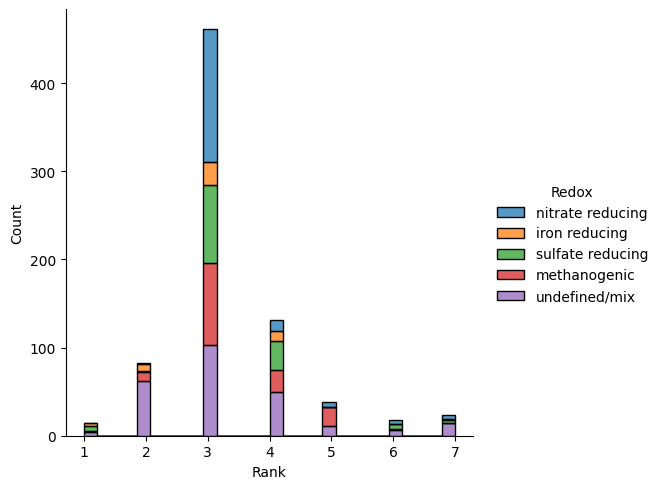

In [34]:
#sns.displot(lit, x='Rank',hue='Redox',multiple='stack').savefig('RedoxRank_dist.png')
#sns.displot(lit, x='Rank',hue='Redox',multiple='fill').savefig('RedoxRank_color.png')
#sns.displot(sub4, x='Rank',hue='Redox',multiple='stack').savefig('RedoxRank_stack_b4.png')
#sns.displot(sub4, x='Rank',hue='Redox',multiple='fill').savefig('RedoxRank_fill_b4.png')
#sns.displot(lit, x='Rank',hue='Redox',multiple='stack').savefig('RedoxRank_stack_b5.png')
#r=sns.displot(lit, x='Rank_3',hue='Redox',multiple='stack',hue_order=["nitrate reducing", "iron reducing", "sulfate reducing","methanogenic","undefined/mix"])
#r.set(xlabel= 'Rank').savefig('RedoxRank_stack_b5_ORDERED.png')
#r=sns.displot(lit, x='Rank',hue='Redox',multiple='fill').savefig('RedoxRank_fill_b5.png')
#sns.displot(lit, x='Rank_3',hue='Redox',multiple='fill',hue_order=["nitrate reducing", "iron reducing", "sulfate reducing","methanogenic","undefined/mix"]).savefig('RedoxRank_fill_b5_ORDERED.png')
#r=sns.displot(lit, x='Rank_3',hue='Redox',multiple='fill',hue_order=["nitrate reducing", "iron reducing", "sulfate reducing","methanogenic","undefined/mix"])
#r.set(xlabel= 'Rank',ylabel='Fraction').savefig('RedoxRank_fill_b5_ORDERED.png')

In [30]:
#print(sns.color_palette('husl',11).as_hex())

In [127]:

# colors={'nitrate reducing':'#35ae95','iron reducing':'#f77189', 'sulfate reducing':'#8f93f4', 'methanogenic':'#b59a32',
#         'nitrate reducing/iron reducing/sulfate reducing/methanogenic':'grey', 'sulfate reducing/methanogenic':'grey', 
#         'iron reducing/sulfate reducing/methanogenic':'grey', 'nitrate reducing/iron reducing/methanogenic':'grey', 
#         'nitrate reducing/sulfate reducing':'grey', 'Undefined':'grey', 'iron reducing/sulfate reducing':'grey'}

# sns.displot(lit, x='Rank', hue='Redox',multiple='fill',palette=colors).savefig('RedoxRank_grey.png')

In [144]:
#get list of schemes with rate supported ranks
rt=pd.read_excel('RankTable_061424.xlsx')
keep=list(rt.loc[rt['Med_HL_days'].notna()==True,'Rxn_Scheme'])
sub=lit[lit['Rxn_Scheme'].isin(keep)==True]

In [133]:
len(lit['Category'].notna()==True)

844

In [134]:
len(lit[(lit['HalfLife (days)'].notna()==True) & (lit['Category'].notna()==True)])

768

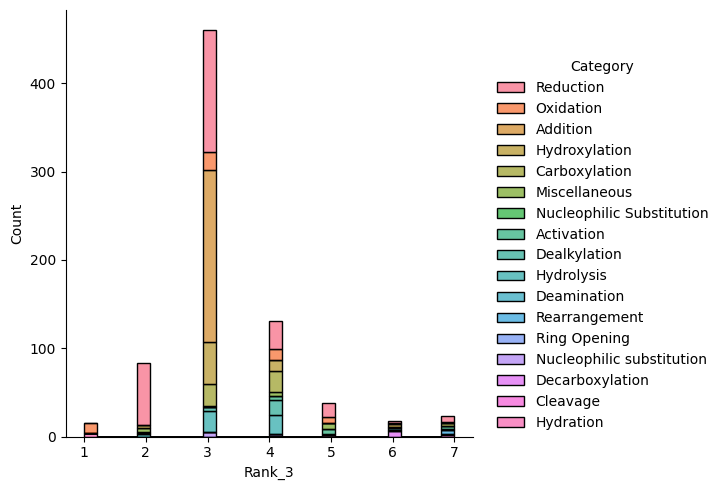

In [145]:
#sns.displot(lit, x='Rank',hue='Category',multiple='fill').savefig('SchemeDist_fill.png')
#sns.displot(lit, x='Rank',hue='Category',multiple='stack').savefig('SchemeDist_stack.png')
sns.displot(sub, x='Rank_3',hue='Category',multiple='stack')
#d=sns.displot(lit, x='Category',hue='Rank',multiple='stack',palette=colors)
#d.set_xticklabels(rotation=45).savefig('SchemeDist_stack_xCat.png')

In [51]:
top=['Activation', 'Hydrolysis','Oxidation','Reduction']
subCat=lit[lit['Category'].isin(top)==True]

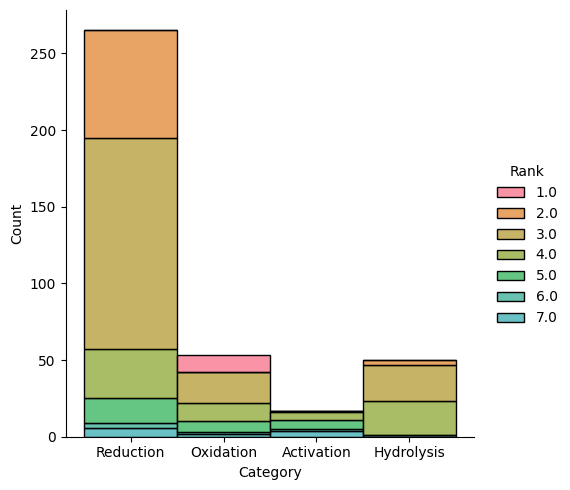

In [59]:
colors={1.0:'#f77189',2.0:'#e18632', 3.0:'#b59a32',4.0: '#8ba731', 5.0:'#32b258',6.0:'#35ae95', 7.0:'#37abb2'}
sns.displot(subCat, x='Category',hue='Rank',multiple='stack',palette=colors).savefig('SchemeDist_stack_xCat_top.png')
#sns.displot(subCat, x='Category',hue='Rank',multiple='fill',palette=colors).savefig('SchemeDist_fill_xCat_top.png')

In [101]:
sub=lit[lit['Category'].notna()==True]
print('mean: ',sub['HalfLife (days)'].astype(float).mean())
print('median: ',sub['HalfLife (days)'].astype(float).median())

mean:  226.33773278631546
median:  10.795705993517865


## Get counts

In [34]:
#total number of rate entries 
len(lit[lit['HalfLife (days)'].notna()==True])

844

In [36]:
#get number of rate entries with a scheme
len(lit[(lit['HalfLife (days)'].notna()==True) & (lit['Rxn_Scheme'].notna()==True)])

769

In [43]:
#total number of rate entries with redox condition
len(lit[(lit['HalfLife (days)'].notna()==True) & (lit['Redox']!='Undefined')])

651

In [45]:
#number of rate entries with a redox contion and scheme assignment
len(lit[(lit['HalfLife (days)'].notna()==True) & (lit['Redox']!='Undefined') &(lit['Rxn_Scheme'].notna()==True)])

601

In [50]:
#number of shcemes with rate data
sub=lit[(lit['HalfLife (days)'].notna()==True)&(lit['Rxn_Scheme'].notna()==True)]
len(sub['Rxn_Scheme'].unique())

89

In [53]:
#number of unique molecules with rate data
len(sub['std_Parent_SMILES'].unique())

196

In [63]:
#population average
sub=lit[(lit['HalfLife (days)'].notna()==True) &(lit['HalfLife (days)']!='stable')]
sub['HalfLife (days)'].astype(float).mean()

224.12754443617806

### AD impact analysis

In [15]:

#subset lit data to only include schemes with AD data
ad_schemes=['Biotic Hydrolysis: Carboxylic Acid Esters','Biotic Hydrolysis: Carbamates',
    'Biotic Hydrolysis: Organophosphorus triester (base-catalyzed)','Dealkylation: O-dealkylation of N-heterocyclic ether',
    'Demethoxylation: N-demethoxylation of methoxy anilines and amines','Nucleophilic Substitution: Halogenated Aromatics','Biotic Hydrolysis: Ureas',
            'Biotic Hydrolysis: Organophosphorus triester (neutral)','Reduction: Dehalogenation of aromatic halides','Biotic Hydrolysis: Nitriles',
            'Biotic Hydrolysis: Amides','Reduction: Hydrogenolysis of haloalkanes']

ad=lit[lit['Rxn_Scheme'].isin(ad_schemes)==True]
ad=ad[ad['HalfLife (days)'].notna()]

In [16]:
#make a duplicate subset and exclude all AD datapoints
no_ad=ad[ad['Anaerobic Digestion']!='Y']
#set all AD rates to 0 (so that we can caluate difference between groups
no_ad_wc=lit[lit['Rxn_Scheme'].isin(ad_schemes)==True]
no_ad_wc=no_ad_wc[no_ad_wc['HalfLife (days)'].notna()]
no_ad_wc.loc[no_ad_wc['Anaerobic Digestion']=='Y','HalfLife (days)']=0
#no_ad_wc['HalfLife (days)']

In [24]:
#perform kruskal wallis on each scheme in ad_schemes
kw_results=pd.DataFrame(columns=['Rxn_Scheme','Median_all','Median_noAD','PopSize_all','PopSize_noAD','test_stat','pval',])
for i in ad_schemes:
    all=list(ad.loc[ad['Rxn_Scheme']==i,'HalfLife (days)'].astype(float))
    med_all=ad.loc[ad['Rxn_Scheme']==i,'HalfLife (days)'].astype(float).median()
    without=list(no_ad.loc[no_ad['Rxn_Scheme']==i,'HalfLife (days)'])
    med_noad=no_ad.loc[no_ad['Rxn_Scheme']==i,'HalfLife (days)'].median()
    pop1=len(all)
    pop2=len(without)
    #print(pop1,pop2)
    stat=scipy.stats.kruskal(all,without).statistic
    pval=scipy.stats.kruskal(all,without).pvalue
    kw_results.loc[len(kw_results)]={'Rxn_Scheme' : i, 'Median_all': round(med_all,3),'Median_noAD':round(med_noad,3), 'PopSize_all': pop1, 'PopSize_noAD': pop2, 
                                'test_stat':round(stat,3), 'pval':round(pval,3)}
kw_results

,Rxn_Scheme,Median_all,Median_noAD,PopSize_all,PopSize_noAD,test_stat,pval
0,Biotic Hydrolysis: Carboxylic Acid Esters,38.000,56.855,13,10,0.348,0.555
1,Biotic Hydrolysis: Carbamates,6.200,6.200,7,5,0.250,0.617
2,Biotic Hydrolysis: Organophosphorus triester (...,5.400,56.500,7,4,0.585,0.444
3,Dealkylation: O-dealkylation of N-heterocyclic...,13.200,26.000,2,1,0.500,0.480
4,Demethoxylation: N-demethoxylation of methoxy ...,0.400,NaN,1,0,NaN,NaN
5,Nucleophilic Substitution: Halogenated Aromatics,19.455,38.500,2,1,0.500,0.480
6,Biotic Hydrolysis: Ureas,16.400,0.001,3,1,1.000,0.317
7,Biotic Hydrolysis: Organophosphorus triester (...,1.175,6.000,8,3,1.871,0.171
8,Reduction: Dehalogenation of aromatic halides,17.325,17.815,73,71,0.008,0.930
9,Biotic Hydrolysis: Nitriles,158.500,159.617,3,2,0.370,0.543


In [47]:
#kw_results.to_excel('AD_KW_Results.xlsx',index=False)


In [27]:
wc_results=pd.DataFrame(columns=['Rxn_Scheme','Median_all','Median_noAD','PopSize_all','PopSize_noAD','test_stat','pval',])
for i in ad_schemes:
    all=ad.loc[ad['Rxn_Scheme']==i,'HalfLife (days)'].astype(float)
    med_all=ad.loc[ad['Rxn_Scheme']==i,'HalfLife (days)'].astype(float).median()
    without=no_ad_wc.loc[no_ad_wc['Rxn_Scheme']==i,'HalfLife (days)'].astype(float)
    noZero=no_ad.loc[no_ad['Rxn_Scheme']==i,'HalfLife (days)'].astype(float)
    med_noad=no_ad.loc[no_ad['Rxn_Scheme']==i,'HalfLife (days)'].median()
    diff=list(all-without)
    pop1=len(all)
    pop2=len(noZero)
    #print(i,diff)
    res=scipy.stats.wilcoxon(diff,method='exact',alternative='less')
    stat=res.statistic
    pval=res.pvalue
    wc_results.loc[len(wc_results)]={'Rxn_Scheme' : i, 'Median_all': med_all,'Median_noAD':med_noad, 'PopSize_all': pop1, 'PopSize_noAD': pop2, 
                                'test_stat':stat, 'pval':pval}
wc_results

,Rxn_Scheme,Median_all,Median_noAD,PopSize_all,PopSize_noAD,test_stat,pval
0,Biotic Hydrolysis: Carboxylic Acid Esters,38.000000,56.855000,13,10,6.0,0.945595
1,Biotic Hydrolysis: Carbamates,6.200000,6.200000,7,5,3.0,0.921350
2,Biotic Hydrolysis: Organophosphorus triester (...,5.400000,56.500000,7,4,6.0,0.948765
3,Dealkylation: O-dealkylation of N-heterocyclic...,13.200000,26.000000,2,1,1.0,0.841345
4,Demethoxylation: N-demethoxylation of methoxy ...,0.400000,NaN,1,0,1.0,1.000000
5,Nucleophilic Substitution: Halogenated Aromatics,19.455000,38.500000,2,1,1.0,0.841345
6,Biotic Hydrolysis: Ureas,16.400000,0.000711,3,1,3.0,0.921350
7,Biotic Hydrolysis: Organophosphorus triester (...,1.175000,6.000000,8,3,15.0,0.983053
8,Reduction: Dehalogenation of aromatic halides,17.325000,17.814910,73,71,3.0,0.910144
9,Biotic Hydrolysis: Nitriles,158.500000,159.616667,3,2,1.0,0.841345


In [28]:
wc_results.to_excel('AD_WC_Results_062624.xlsx',index=False)

In [30]:
ad.loc[ad['Rxn_Scheme']=='Biotic Hydrolysis: Ureas','HalfLife (days)'].median()

16.4

In [32]:
ad.loc[ad['Rxn_Scheme']=='Biotic Hydrolysis: Ureas','Anaerobic Digestion']

884     N
1019    Y
1071    Y
Name: Anaerobic Digestion, dtype: object